## Librerias

In [ ]:
import pandas as pd
from ppi_client.api.constants import ACCOUNTDATA_TYPE_ACCOUNT_NOTIFICATION, ACCOUNTDATA_TYPE_PUSH_NOTIFICATION, \
    ACCOUNTDATA_TYPE_ORDER_NOTIFICATION
from ppi_client.models.account_movements import AccountMovements
from ppi_client.models.order import Order
from ppi_client.ppi import PPI
from ppi_client.models.disclaimer import Disclaimer
from ppi_client.models.instrument import Instrument
from datetime import datetime, timedelta
import asyncio
import json
import traceback
import os


In [ ]:
# Change sandbox variable to False to connect to production environment
ppi = PPI(sandbox=False)

In [ ]:
key_publica="TnAzYWFDU3JYZDZuVW82RE16RTc="
key_privada="ODIxMzUxOTctZmMxNy00OGRhLWI2OTItNTc5MzFhMjZlMmZl"

In [ ]:
def account():
    try:
        # Change login credential to connect to the API
        ppi.account.login_api(key_publica, key_privada)

        # Getting accounts information
        print("Getting accounts information")
        account_numbers = ppi.account.get_accounts()
        for account in account_numbers:
            print(account)
        account_number = account_numbers[0]['accountNumber']
    except Exception as message:
        print(datetime.now())
        print(message)



In [ ]:
account()

## Parametros

Response Settlements: [
    "INMEDIATA",
    "A-24HS",
    "A-48HS",
    "A-72HS"
]

Response Markets:[
    "ROFEX",
    "OTC",
    "NYSE",
    "BYMA"
]

Response Instrument Types:[
    "BONOS",
    "LETRAS",
    "NOBAC",
    "LEBAC",
    "ON",
    "FCI",
    "CAUCIONES",
    "ACCIONES",
    "ETF",
    "CEDEARS",
    "OPCIONES",
    "FUTUROS",
    "ACCIONES-USA",
    "FCI-EXTERIOR"
]

In [ ]:
dateFrom=datetime(2023, 1, 1)
dateTo=datetime(2025, 4, 8)
ticker="TENC"
instrument_type="CEDEARS"
settlements="A-24HS"

In [ ]:
def search_Instrument():
    print("\nSearching instruments")
    instruments = ppi.marketdata.search_instrument(ticker=ticker,instrument_name="",market="NYSE")
    for ins in instruments:
        print(ins)    

In [ ]:
search_Instrument()

In [91]:
def historic_Master_Data():
# Ticker
# Search Historic MarketData
    print("\nSearching MarketData")
    market_data = ppi.marketdata.search(ticker=ticker,instrument_type=instrument_type,
                                        settlement=settlements,date_from=dateFrom,date_to=dateTo)
    
    for ins in market_data:
        print("%s - %s - Volume %s - Opening %s - Min %s - Max %s" % (
                    ins['date'], ins['price'], ins['volume'], ins['openingPrice'], ins['min'], ins['max']))


In [93]:
historic_Master_Data()


Searching MarketData
2023-01-02T00:00:00-03:00 - 13.3 - Volume 6019.7 - Opening 13 - Min 12.75 - Max 13.35
2023-01-03T00:00:00-03:00 - 13.2 - Volume 65452.8 - Opening 13.35 - Min 12.65 - Max 13.35
2023-01-04T00:00:00-03:00 - 12.85 - Volume 34530.55 - Opening 13.2 - Min 12.75 - Max 13.5
2023-01-05T00:00:00-03:00 - 12.8 - Volume 94021.7 - Opening 13.2 - Min 12.7 - Max 13.2
2023-01-06T00:00:00-03:00 - 13 - Volume 108434.7 - Opening 13.15 - Min 12.85 - Max 13.15
2023-01-09T00:00:00-03:00 - 12.95 - Volume 52828.25 - Opening 13 - Min 12.9 - Max 13.2
2023-01-10T00:00:00-03:00 - 12.95 - Volume 59275.9 - Opening 12.8 - Min 12.6 - Max 13
2023-01-11T00:00:00-03:00 - 12.85 - Volume 53619.55 - Opening 12.95 - Min 12.5 - Max 13
2023-01-12T00:00:00-03:00 - 12.45 - Volume 85063.25 - Opening 12.8 - Min 12.4 - Max 12.8
2023-01-13T00:00:00-03:00 - 12.65 - Volume 81458.8 - Opening 12.45 - Min 12.25 - Max 12.6
2023-01-16T00:00:00-03:00 - 12.65 - Volume 23342.6 - Opening 12.75 - Min 12.25 - Max 12.75
2023-

In [94]:
def historic_Master_Data_to_csv(ticker):
    
    try:
        print("\nSearching MarketData")
        market_data = ppi.marketdata.search(ticker=ticker,instrument_type=instrument_type,
                                            settlement=settlements,date_from=dateFrom,date_to=dateTo)
        
        data = []
        for ins in market_data:
            data.append({
                'Date': ins['date'],
                'Price': ins['price'],
                'Volume': ins['volume'],
                'Opening': ins['openingPrice'],
                'Min': ins['min'],
                'Max': ins['max'],
                'ticker': ticker,
                'settlement': settlements,
                'instrument_type': instrument_type,
                'currency': "USD"
            })
    # Convertir la lista de diccionarios en un DataFrame
        df = pd.DataFrame(data)
        # Convertir la columna 'Date' a tipo datetime
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce') 
        df = df.sort_values(by='Date')
        # # Calculo la variación diaria 
        df['variacion_diaria'] = df['Price'].pct_change() * 100  # Variación en porcentaje    

        file_name = 'market_data.csv'
        
        df.to_csv(file_name, mode='a', header=not pd.io.common.file_exists(file_name), index=False)
        print(f"Datos agregados al archivo {file_name}")
    except Exception as e:
        print(f"Error al guardar los datos: {e}, ticker:{ticker}")

In [95]:
tickers=["TEND","AAPLD","VISTD","DESPD","MELID","XOMD","NVDAD","MSFTD","KOD"]
for ticker in tickers:
    historic_Master_Data_to_csv(ticker)


Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv

Searching MarketData
Datos agregados al archivo market_data.csv


Grafico Todas las series

In [ ]:
import matplotlib.pyplot as plt

# Leer el archivo CSV con los datos acumulados
file_name = 'market_data.csv'
df = pd.read_csv(file_name)

# Asegurarse de que la columna 'Date' sea de tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Graficar cada ticker como una serie separada
plt.figure(figsize=(12, 6))
for ticker in df['ticker'].unique():
    ticker_data = df[df['ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Price'], label=ticker)

# Personalizar el gráfico
plt.title('Evolución de Precios por Ticker')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(title='Ticker')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Grafico por ticker

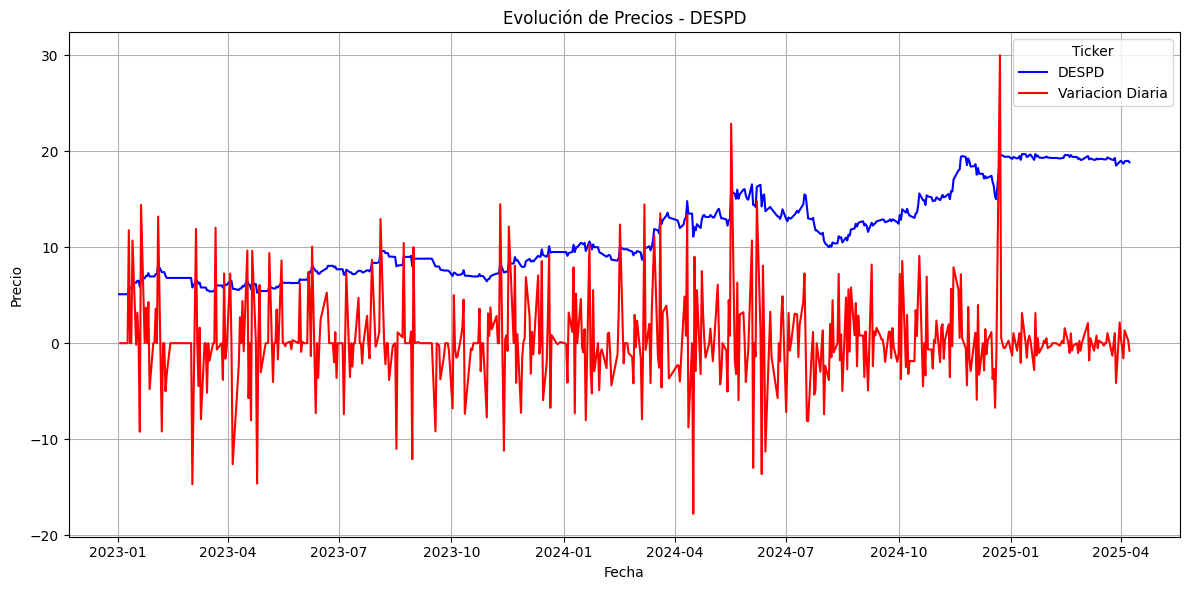

In [ ]:

# Leer el archivo CSV con los datos acumulados
file_name = 'market_data.csv'
df = pd.read_csv(file_name)

# Asegurarse de que la columna 'Date' sea de tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filtrar los datos para el ticker 'DESPD'
df_despd = df[df['ticker'] == 'DESPD']

# Graficar los datos de 'DESPD'
plt.figure(figsize=(12, 6))
plt.plot(df_despd['Date'], df_despd['Price'], label='DESPD', color='blue')
plt.plot(df_despd['Date'], df_despd['variacion_diaria'], label='Variacion Diaria', color='red')

# Personalizar el gráfico
plt.title('Evolución de Precios - DESPD')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(title='Ticker')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()